# Procedurally generated worlds using Pandas and Numpy
I'm a big fan of rouge-like games and RPGs. I'm also a big fan of data science tools for Python. This is my attempt to have it all. 

In [2]:
import pandas as pd
import numpy as np
import pickle

import altair as alt

#importing local libraries for drawings (because they clutter)
#I'm mapping to the actual files in the repo so that I can also use this to troubleshoot
import sys
sys.path.append('../')
from lib.builders import world as w, landscape as l
import lib.drawMaps as draw


There are default parameters that I've chosen as the best fit for creating a _'believable'_ world. You can experiment with those variables by editing them here. They won't affect the production parameters. 

In [3]:
l.default_params

{'grid': [40, 40], 'N_loc': 0, 'N_std': 1}

In [4]:
landscape = l.Landscape()
landscape

I'm going to use the `landscape` over and over to specify the world's parameters. Some of the parameters are set by the user and some of them are hard cast. 

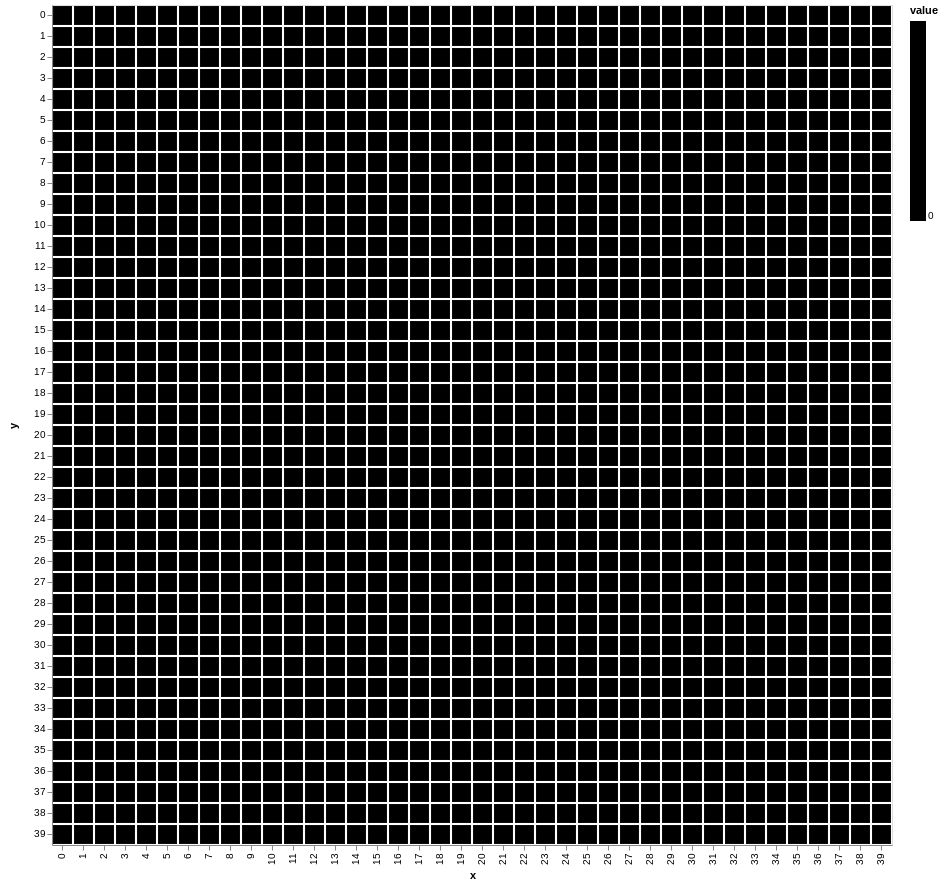

In [5]:
world = w.World(landscape)
draw.drawTerrainHeight(world.grid_elevation)

# in the beginning, the world was void and without form.

Starting with a grid with nothing on it. No elevation, no terrain. All of this will be generated proceduraly. 

You can see here that the terrain is shifted on a random-normal distribution to make it look _uneven_. Making it randomly doesn't make it look _real_ so I'm going to have to be smarter about the rules that raise and lower terrain in order to make them look like mountains. 

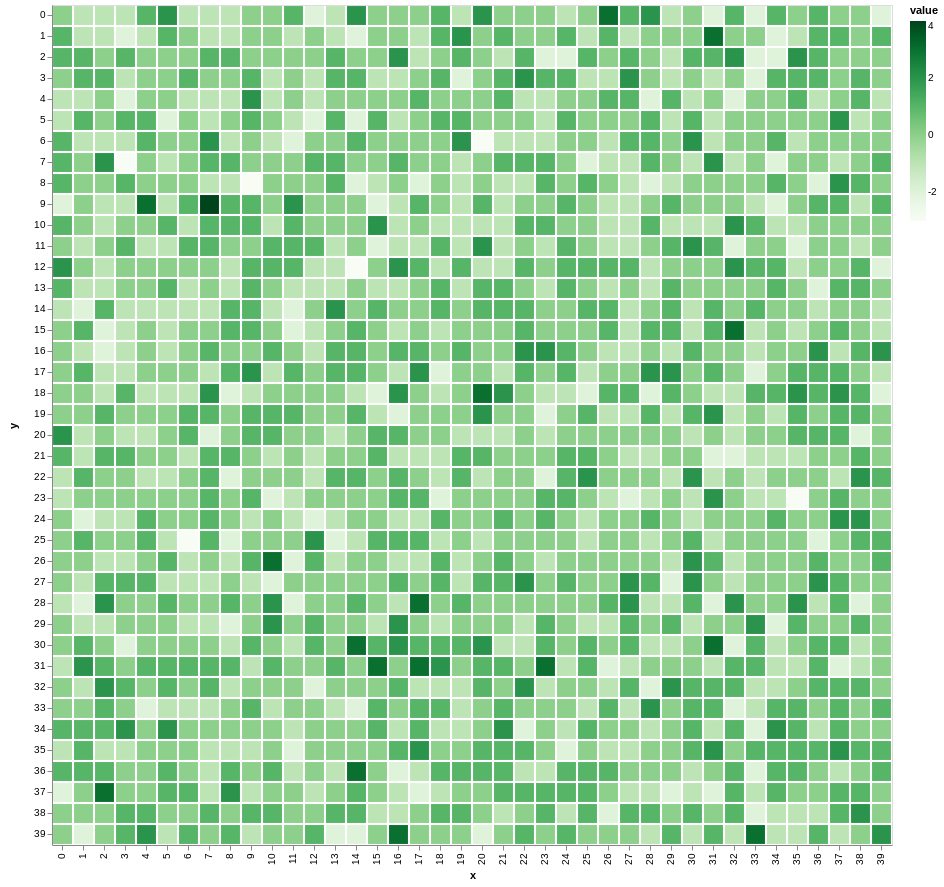

In [6]:
world.shift_terrain()
draw.drawTerrainHeight(world.grid_elevation)

Just random terrain shifting won't make anything like real terrain types. 

# Mountains formed

Using Np.pad to build a pyramid, I'm making something that looks much more like a mountain. This is just a single mountain. 

In [7]:
world.getMountain()

,0,1,2
0,1,1,1
1,1,2,1
2,1,1,1


This is great, but I need to place the mountain on a random place on the terrain. Currently just drop the edges of the mountain if they go off the grid. I might wrap them around later. **Note** height needs to be odd in order to draw symetrically.

In [8]:
c = world.get_random_chord()
m = world.getMountain(height=5)
print("Mountain Placed: ", c)

mdf = world.reindexMountain(c,m)
mdf

Mountain Placed:  [18 35]


,31,32,33,34,35,36,37,38,39
14,1,1,1,1,1,1,1,1,1
15,1,2,2,2,2,2,2,2,1
16,1,2,3,3,3,3,3,2,1
17,1,2,3,4,4,4,3,2,1
18,1,2,3,4,5,4,3,2,1
19,1,2,3,4,4,4,3,2,1
20,1,2,3,3,3,3,3,2,1
21,1,2,2,2,2,2,2,2,1
22,1,1,1,1,1,1,1,1,1


This makes a much more _natural_ looking mountain. 

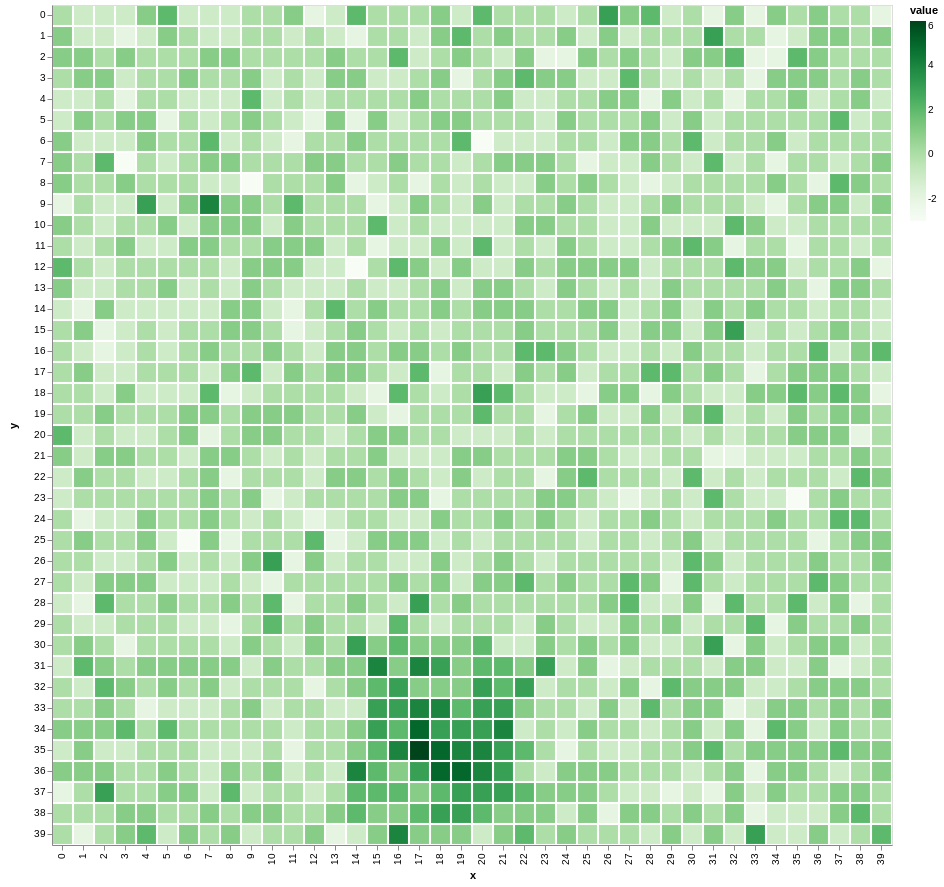

In [9]:
world.add_mountain(mdf)
draw.drawTerrainHeight(world.grid_elevation)

It's a good looking mountain, but I need mountain ranges not dots. In order to drag mountains on the board (like Sim City) I'll need to create a brownian motion function to drop a mountain and then move. 

In [10]:
world.brownian_land()

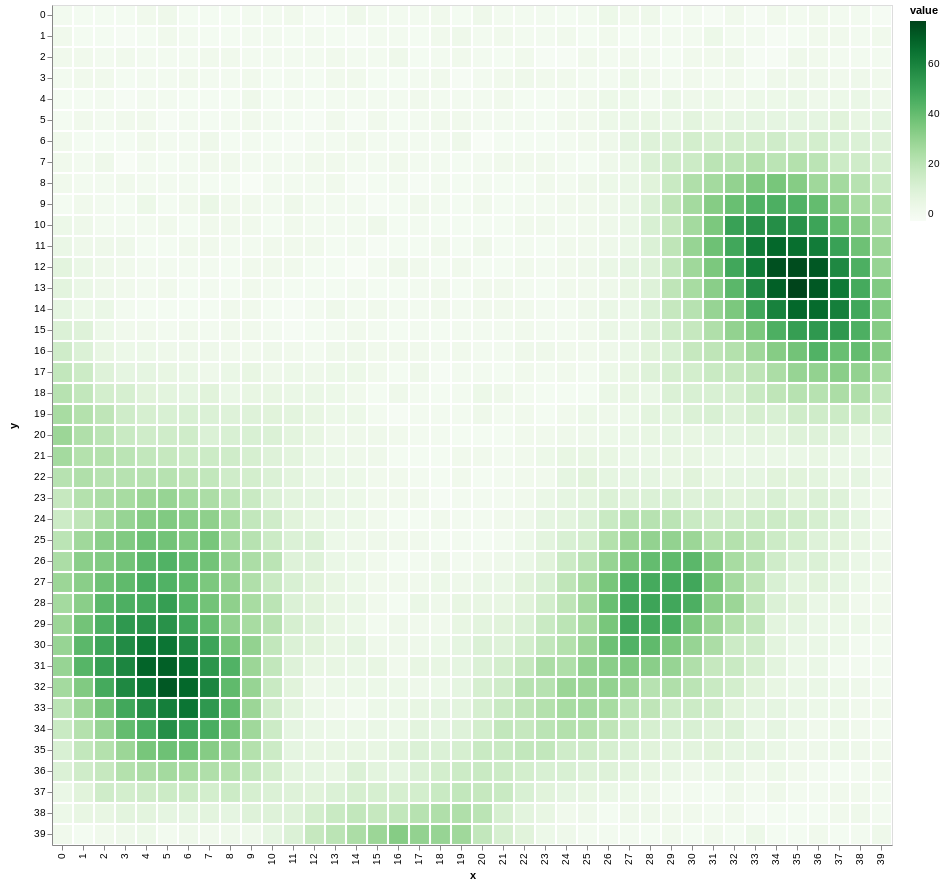

In [11]:
draw.drawTerrainHeight(world.grid_elevation)

Now that's starting to look like land. The shapes come out really map-like. Compute time is lower than my previous version as well. Only drawing the Altair viz takes time. 

## Oceans

If the oceans were to come in at `heignt == 0` then you can assume that lower terrain is _under water_

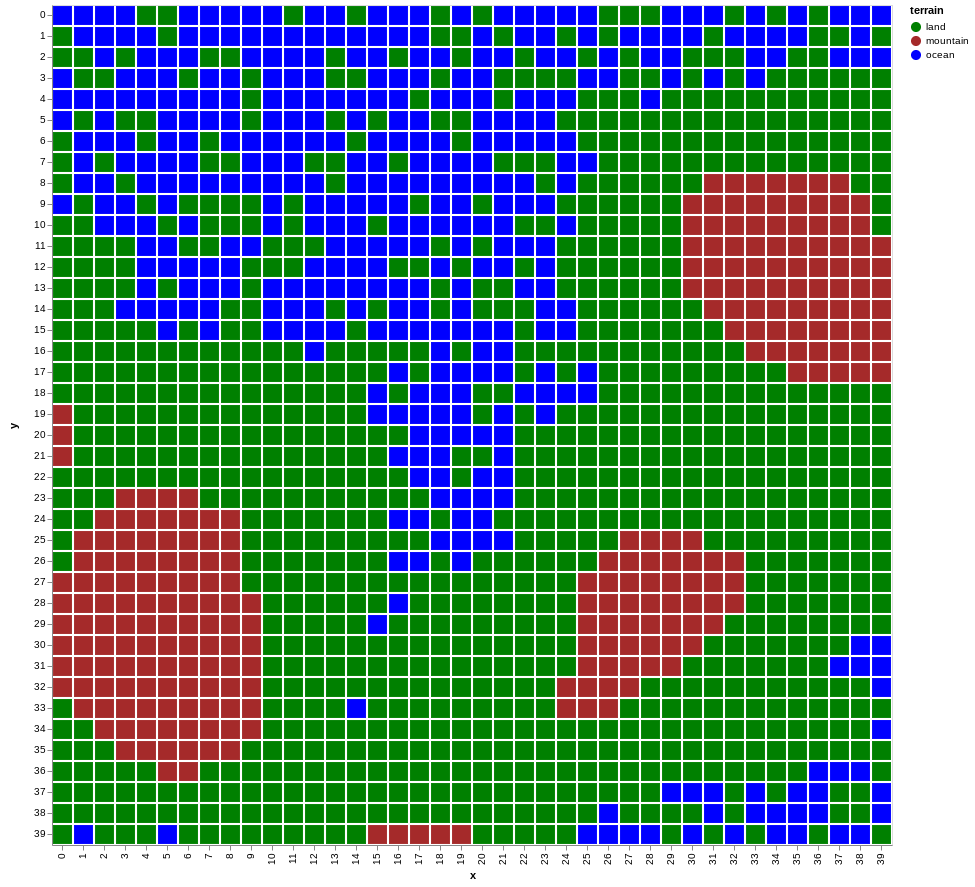

In [12]:
draw.drawTerrainTypes(world.grid_elevation,world.landscape)

### Rivers

The idea of rivers is to start at the top of a mountain and flow down to the sea. 

In [13]:
world.brownian_rainfall()

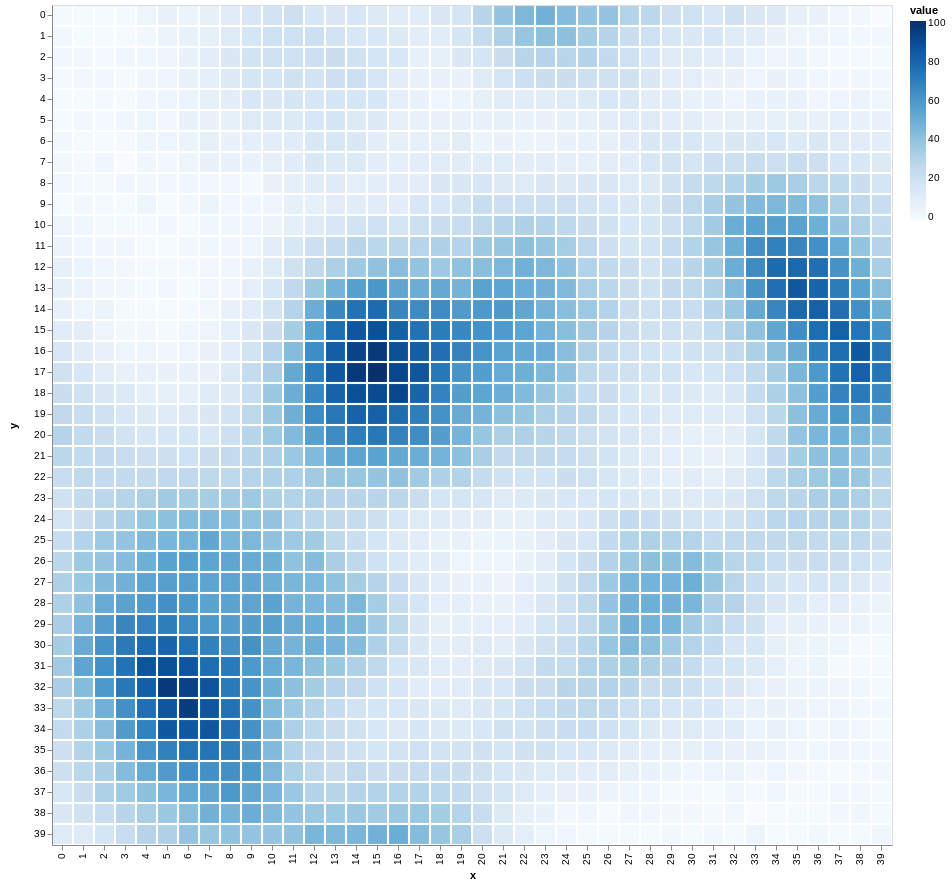

In [14]:
draw.drawRainFall(world.grid_rainfall)

### Saving the local copy

Saving a local copy of the pickled file for update. TODO: add function to save pickle in S3

In [16]:
world.build_df_features()
world.df_features.head(10)

,y,rainfall,x,key,elevation,terrain
key,,,,,,
0:0,0,0.0,0,0:0,0.0,ocean
1:0,0,-1.0,1,1:0,-1.0,ocean
2:0,0,-1.0,2,2:0,-1.0,ocean
3:0,0,0.0,3,3:0,-1.0,ocean
4:0,0,3.0,4,4:0,1.0,land
5:0,0,5.0,5,5:0,2.0,land
6:0,0,4.0,6,6:0,-1.0,ocean
7:0,0,7.0,7,7:0,-1.0,ocean
8:0,0,10.0,8,8:0,-1.0,ocean


In [17]:
with open('world_1.p', 'wb') as pickle_file:
    pickle.dump(world, pickle_file)